### TOPIC ANALYSIS OF SONGS FROM 1965-2015

In [1]:
import warnings
warnings.filterwarnings('ignore')

Import Packages/Libraries

In [15]:
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk import sent_tokenize,word_tokenize 

import numpy as np
import pandas as pd


# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint

# # Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
# !pip3 install spacy

#### Load the Lyrics Data and Clean it 


In [3]:
df = pd.read_csv("billboard_lyrics_1964-2015.csv", encoding = "ISO-8859-1")
df[1:]
df["Lyrics"] = df["Lyrics"].apply(lambda x: str(x))
text_lyrics = df.Lyrics.values
# text_lyrics = ' '.join(text_lyrics)

In [4]:
STOPWORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

###  Add more stopwords

#### These words are mostly sounds or filler words and dont contribute to the meaning of the song

In [5]:
add_stopwords = ["im", "oh", "yeah", "da","em","ya", "hey", "whoa", "wit","uh","like", "na", "la", "ooh", "got", "aint", "gone","youre", "let", "cause","come","dont","gon", "know"]

#### Word tokenize the data. Convert each sentence into a list of words

In [6]:
lyrics = [[word for word in str(track).lower().split()
        if word not in STOPWORDS and word not in add_stopwords and word.isalnum()]
        for track in text_lyrics]

In [7]:
lyrics

[['sam',
  'sham',
  'miscellaneous',
  'wooly',
  'bully',
  'wooly',
  'bully',
  'sam',
  'sham',
  'pharaohs',
  'domingo',
  'samudio',
  'uno',
  'dos',
  'tres',
  'quatro',
  'matty',
  'told',
  'hatty',
  'thing',
  'saw',
  'big',
  'horns',
  'wooly',
  'jaw',
  'wooly',
  'bully',
  'wooly',
  'bully',
  'wooly',
  'bully',
  'wooly',
  'bully',
  'wooly',
  'bully',
  'hatty',
  'told',
  'matty',
  'lets',
  'chance',
  'lets',
  'belseven',
  'learn',
  'dance',
  'wooly',
  'bully',
  'wooly',
  'bully',
  'wooly',
  'bully',
  'wooly',
  'bully',
  'wooly',
  'bully',
  'matty',
  'told',
  'hatty',
  'thats',
  'thing',
  'pull',
  'wool',
  'wooly',
  'bully',
  'wooly',
  'bully',
  'wooly',
  'bully',
  'wooly',
  'bully',
  'wooly',
  'bully',
  'lseven',
  'letter',
  'l',
  'number',
  '7',
  'typed',
  'form',
  'rough',
  'square',
  'l7',
  'lyrics',
  'mean',
  'lets',
  'square'],
 ['sugar',
  'pie',
  'honey',
  'bunch',
  'love',
  'help',
  'love',
  'e

#### Try seeing the most common words in one song using collections.Counter()

In [8]:
import collections

counter = collections.Counter(lyrics[5001])
counter.most_common(20)
counts = [(word, count) for word, count in counter.most_common()]
counts

[('love', 10),
 ('maybe', 6),
 ('thinking', 5),
 ('right', 5),
 ('loving', 4),
 ('baby', 4),
 ('heart', 4),
 ('fall', 4),
 ('arms', 3),
 ('kiss', 3),
 ('light', 3),
 ('thousand', 3),
 ('stars', 3),
 ('place', 3),
 ('head', 3),
 ('beating', 3),
 ('loud', 3),
 ('remember', 2),
 ('darling', 2),
 ('bout', 2),
 ('people', 2),
 ('mysterious', 2),
 ('ways', 2),
 ('honey', 2),
 ('legs', 1),
 ('work', 1),
 ('sweep', 1),
 ('feet', 1),
 ('mouth', 1),
 ('taste', 1),
 ('eyes', 1),
 ('smile', 1),
 ('cheeksand', 1),
 ('til', 1),
 ('70', 1),
 ('hard', 1),
 ('23', 1),
 ('touch', 1),
 ('hand', 1),
 ('single', 1),
 ('day', 1),
 ('wanna', 1),
 ('tell', 1),
 ('amso', 1),
 ('arewhen', 1),
 ('hairs', 1),
 ('memory', 1),
 ('fades', 1),
 ('crowds', 1),
 ('hands', 1),
 ('play', 1),
 ('strings', 1),
 ('way', 1),
 ('mm', 1),
 ('samecause', 1),
 ('soul', 1),
 ('grow', 1),
 ('old', 1),
 ('evergreen', 1),
 ('smiles', 1),
 ('forever', 1),
 ('mind', 1),
 ('memoryim', 1),
 ('plan', 1),
 ('ill', 1),
 ('making', 1),
 ('m

<h2> LDA</h2>

<h4>Create a (word,frequency) dictionary for each word in the text</h4>
<li>dictionary: key = word, value = integer corpora.Dictionary generates this.
<li>corpus: A list of (word index, frequency) pairs for each text. doc2bow generates this

In [9]:
#Set parameters
num_topics = 2 #The number of topics that should be generated
passes = 20
dictionary = corpora.Dictionary(lyrics)
corpus = [dictionary.doc2bow(text) for text in lyrics]

lda = LdaModel(corpus,
              id2word=dictionary,
              num_topics=num_topics,
              passes=passes)

In [10]:
len(corpus)

5100

In [11]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_words=8))

from operator import itemgetter
lda.get_document_topics(corpus[0],minimum_probability=0.05,per_word_topics=False)
sorted(lda.get_document_topics(corpus[5099],minimum_probability=0,per_word_topics=False),key=itemgetter(1),reverse=True)


[   (   0,
        '0.009*"girl" + 0.008*"wanna" + 0.007*"want" + 0.006*"rock" + '
        '0.005*"baby" + 0.005*"right" + 0.005*"shake" + 0.005*"money"'),
    (   1,
        '0.034*"love" + 0.019*"baby" + 0.011*"want" + 0.011*"time" + '
        '0.009*"gonna" + 0.009*"ill" + 0.009*"way" + 0.008*"wanna"')]


[(1, 0.97426903), (0, 0.025730908)]

In [12]:
def draw_wordcloud(lda,topicnum,min_size=0,STOPWORDS=[]):
    word_list=[]
    prob_total = 0
    for word,prob in lda.show_topic(topicnum,topn=50):
        prob_total +=prob
    for word,prob in lda.show_topic(topicnum,topn=50):
        if word in STOPWORDS or  len(word) < min_size:
            continue
        freq = int(prob/prob_total*1000)
        alist=[word]
        word_list.extend(alist*freq)

    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    %matplotlib inline
    from random import shuffle
    shuffle(word_list)
    text = ' '.join(word_list)
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',max_words=20).generate(text)

    plt.axis('off')
    plt.imshow(wordcloud)

    return None

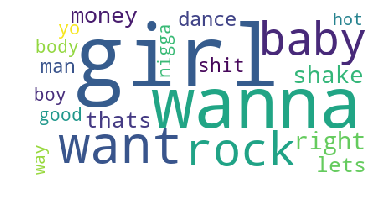

In [13]:
draw_wordcloud(lda,0)

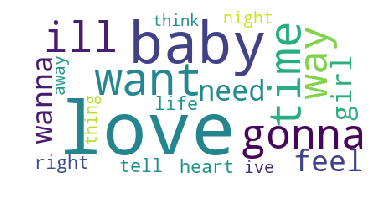

In [14]:
draw_wordcloud(lda,1)

### CONCLUSIONS

### The two topics are very similar and the predominant theme is love and women. Top songs have all been about loving women for the past six decades!

#### However, an interesting thing to notice is how the use of expletives is much more visible in first topic (topic 0)!